In [1]:
#Identifying Drivers of Outcomes: Linear Models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.stats import anova as sms_anova

#Loading in the amusement park data set
# sat_df = pd.read_csv('http://bit.ly/PMR-ch7')
# sat_df.sample(5)

#Simulating amusement park data

np.random.seed(8266)
n_resp = 500

halo = np.random.normal(loc = 0, scale = 5, size = n_resp)

def genereate_satisfatcion_scores(mean, std, halo,
                                  score_range = (0,100)):
    """Simulate satisfaction scores of a survey questions from a normal distribution"""
    #Draws scores from norm. dist
    scores = np.random.normal(loc = mean, scale = std, size = len(halo))
    #Adds the halo
    scores = scores + halo
    #Floor the scores so they are all integers and clip to limit range
    scores = np.floor(scores)
    scores = np.clip(scores, score_range[0],score_range[1])
    
    return scores

rides = genereate_satisfatcion_scores(mean = 81, std = 3 , halo = halo)
games = genereate_satisfatcion_scores(mean = 75, std = 2, halo = halo)
wait = genereate_satisfatcion_scores(mean = 74, std = 10, halo = halo)
clean = genereate_satisfatcion_scores(mean = 86, std = 2, halo = halo)

np.random.seed(82667)
distance = np.random.lognormal(mean = 3, sigma = 1,  size = n_resp)
num_child = np.random.choice(a = range(6),
                             size = n_resp,
                             replace = True,
                             p = [0.3,0.15,0.25,0.15,0.1,0.05])
weekend = np.random.choice(a = [True, False],
                           size = n_resp,
                           p = [0.5,0.5])

overall = np.floor(0.7 * (halo + 0.5 * rides + 0.15 * games + 0.3 * wait
                          + 0.2 * clean + 0.07 * distance + 5 * (num_child == 0)
                          + 0.3 * wait * (num_child > 0)
                          + np.random.normal(loc = 0, scale = 7, size = n_resp)))
overall = np.clip(overall,0,100)

sat_df = pd.DataFrame({'is_weekend': weekend,
                       'num_child':num_child,
                       'distance':distance,
                       'rides': rides,
                       'games': games,
                       'wait': wait,
                       'clean': clean,
                       'overall':overall})

sat_df.head(5)

,is_weekend,num_child,distance,rides,games,wait,clean,overall
0,True,0,9.844503,82.0,74.0,82.0,88.0,70.0
1,False,1,2.720221,85.0,80.0,100.0,90.0,100.0
2,False,3,1.878189,88.0,82.0,80.0,91.0,95.0
3,False,0,14.211682,73.0,61.0,68.0,74.0,56.0
4,False,1,9.362776,78.0,77.0,56.0,82.0,61.0


/var/folders/m8/j9f34b0132b375sgqgzj51240000gn/T/ipykernel_22843/3589111992.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  g = sns.PairGrid(sat_df.replace({False: 0, True: 1}))


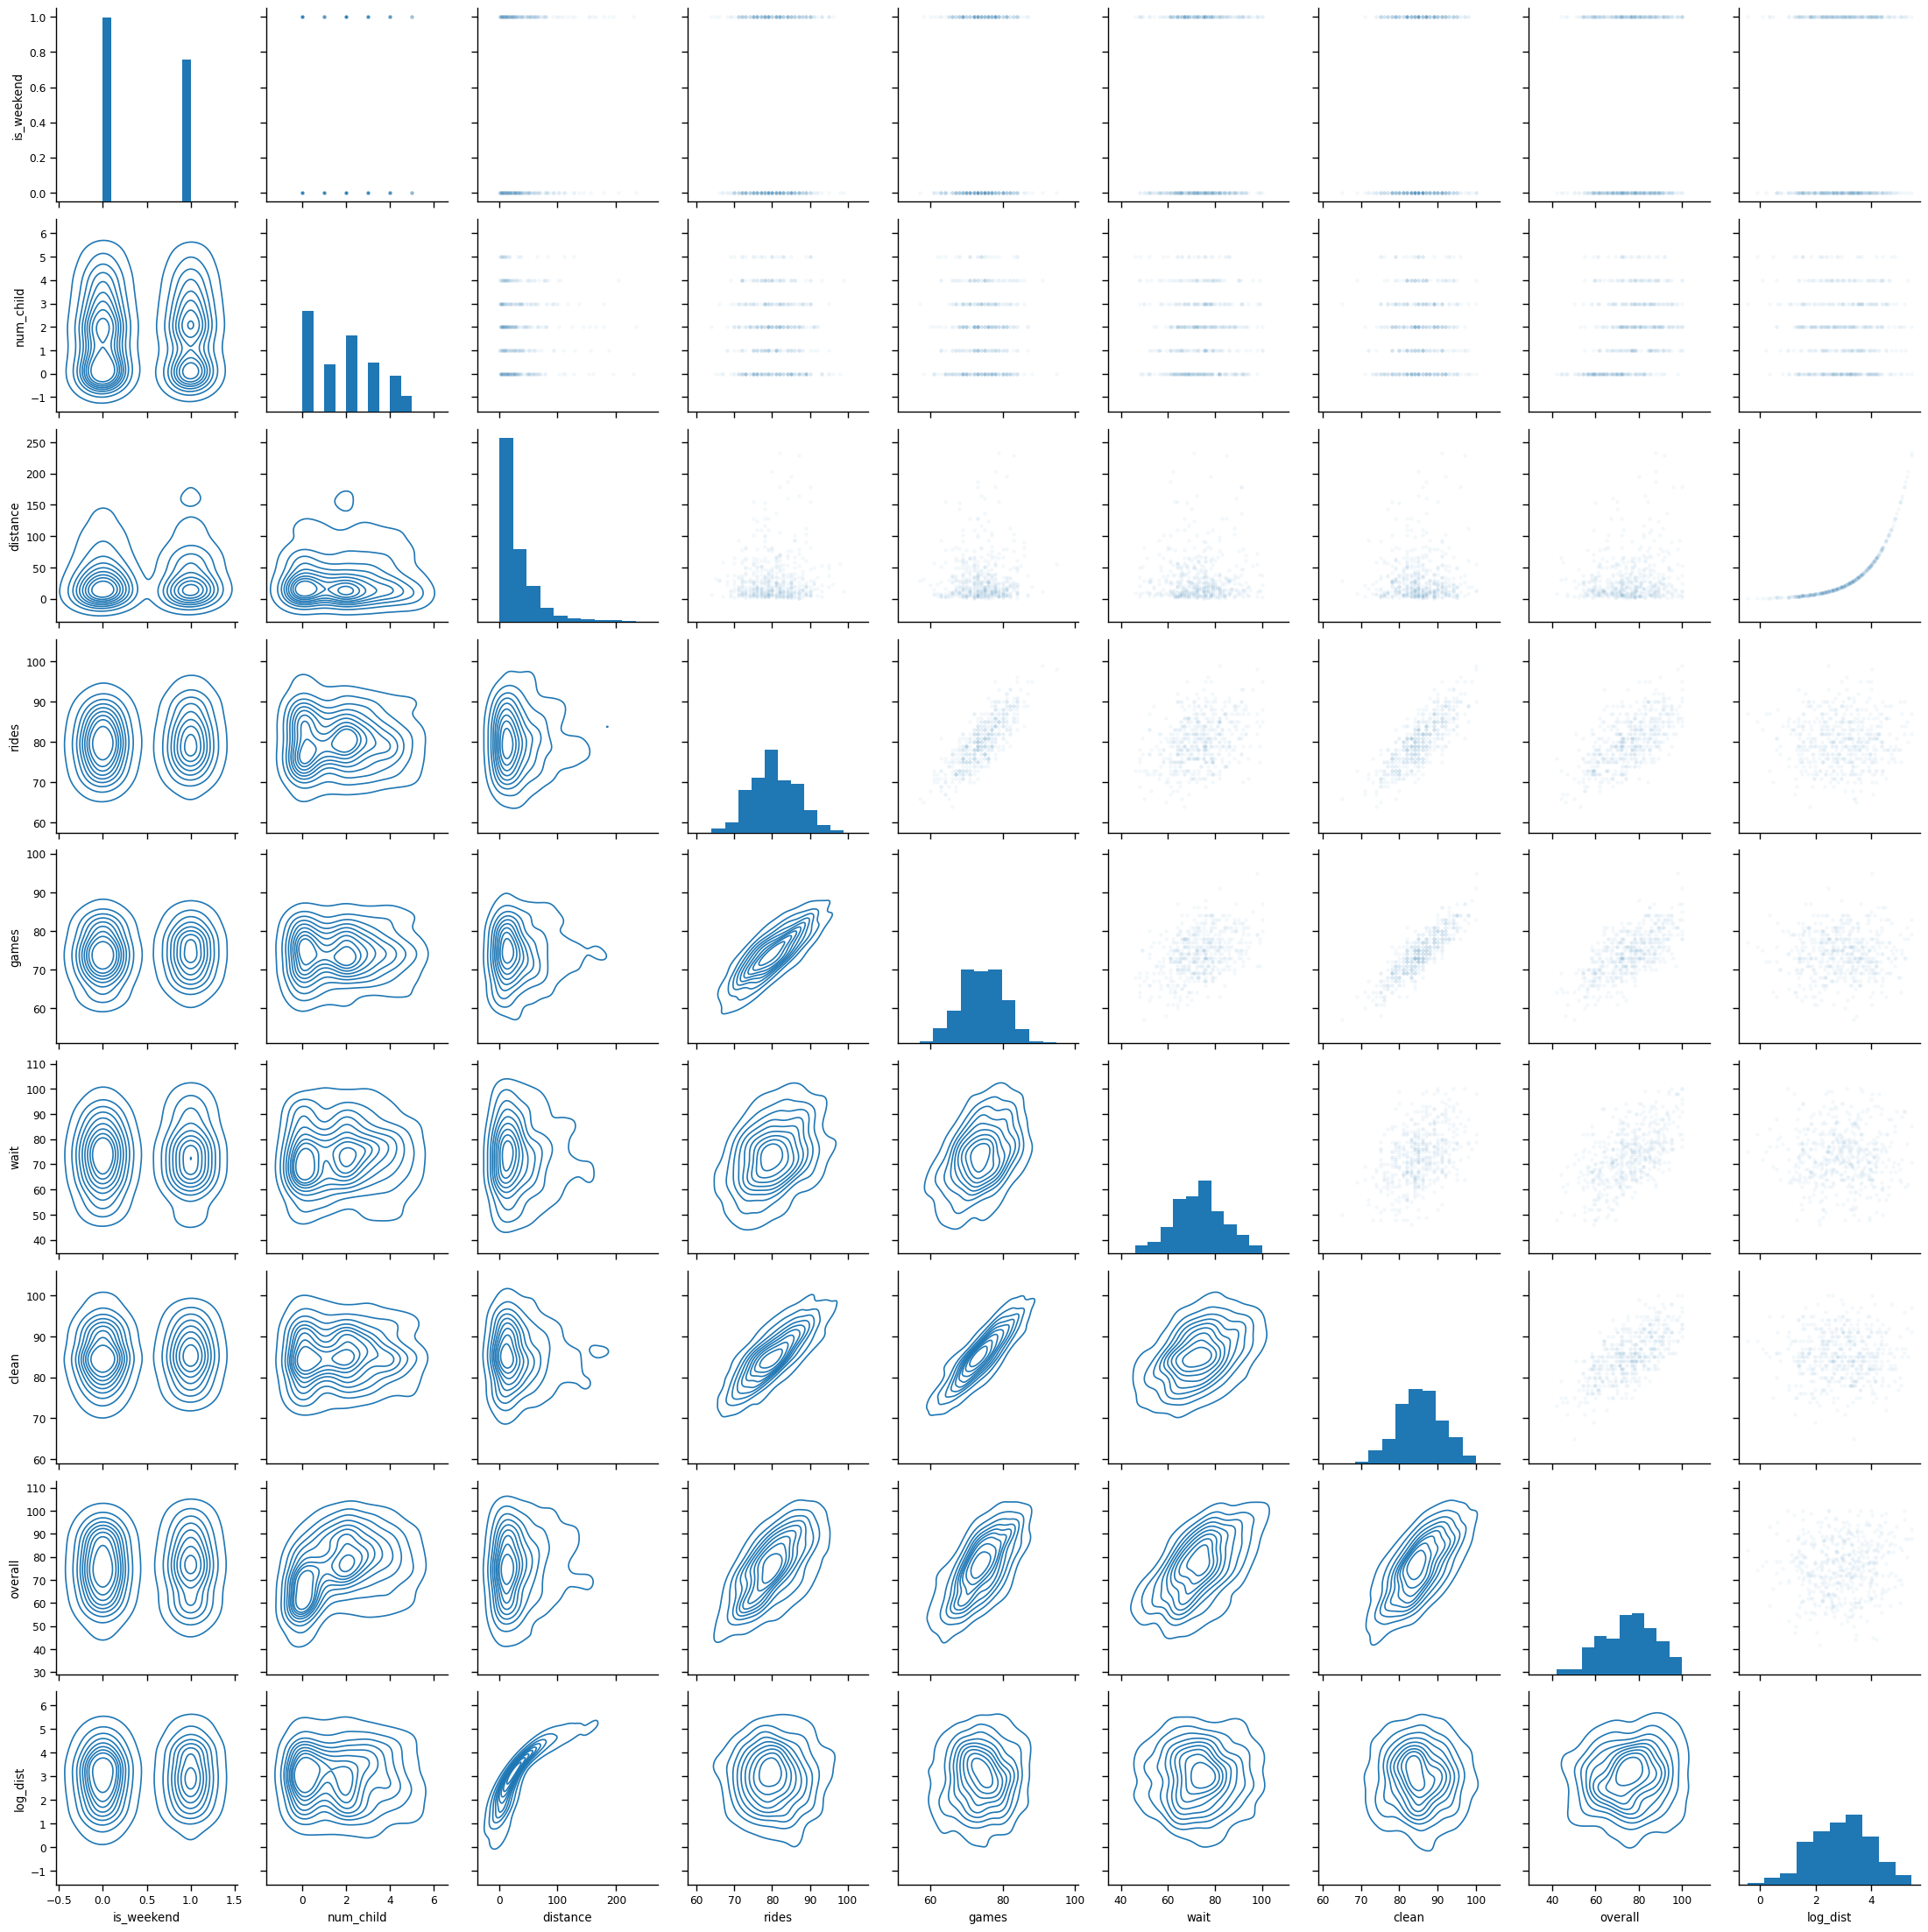

<Axes: >

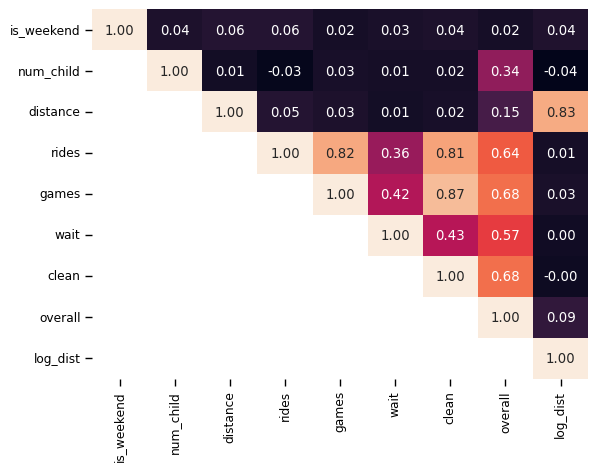

In [12]:
#Preliminary Data Inspection

#Looking at summary stats of dataframe 
sat_df.describe(include = 'all').T.round(2)

#Checking reasonable dist. and joint relationship using seaborn
sns.set_context('paper')

g = sns.PairGrid(sat_df.replace({False: 0, True: 1}))
g.map_upper(sns.scatterplot, linewidth = 1, edgecolor = "w", s = 10,
            alpha = 0.05)
g.map_diag(plt.hist)
g.map_lower(sns.kdeplot)

#adding log of dist. to make more normally dist. 
sat_df['log_dist'] = sat_df.distance.apply(np.log)
sat_df.log_dist.hist()
plt.xlabel('log distance')
plt.ylabel('count')
plt.show()

#Looking at the positive associations
sat_df_corr = sat_df.corr()
sns.heatmap(sat_df_corr, annot = True, fmt = ".2f",
            mask = np.tri(sat_df_corr.shape[1], k = -1, dtype = bool),
            cbar = False)

Text(0, 0.5, 'Satisfaction Overall')

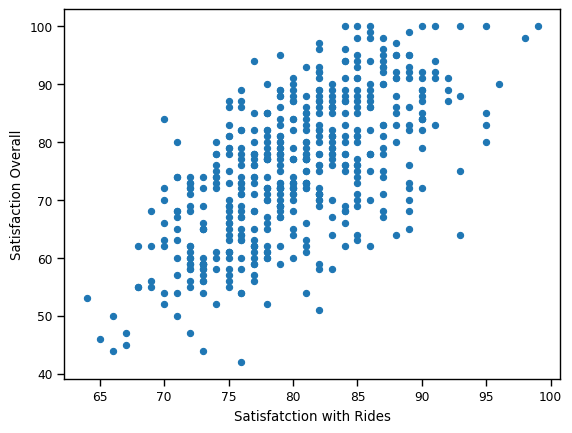

In [13]:
#Recap: Bivariate Association

#Checking Relationship: is it strong or weak using scatterplot
sat_df.plot(kind = "scatter",x = 'rides', y = 'overall')
plt.xlabel("Satisfatction with Rides")
plt.ylabel("Satisfaction Overall")

In [14]:
#linear Model with a Single Predictor

smf.ols('overall ~ rides', data = sat_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                overall   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     345.3
Date:                Tue, 12 Aug 2025   Prob (F-statistic):           6.14e-59
Time:                        16:06:55   Log-Likelihood:                -1824.4
No. Observations:                 500   AIC:                             3653.
Df Residuals:                     498   BIC:                             3661.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -27.9075      5.572     -5.008      0.000     -38.855     -16.960
rides          1.2878      0.069     18.582      0.000       1.152       1.424
==============================================================================
Omnibus:                        4.927   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.085   Jarque-Bera (JB):                4.605
Skew:                          -0.183   Prob(JB):                        0.100
Kurtosis:                       2.704   Cond. No.                     1.08e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""